In [1]:
#Documents/Projects/Bridgerton/Reddit/r_BridgertonNetflix_comments.jsonl
#https://arctic-shift.photon-reddit.com/download-tool


# Bridgerton Official Episode Discussion Reddit Threads Sentiment Analysis 

 * Dataset was downloaded using https://arctic-shift.photon-reddit.com/download-tool which provides jsonl
 * Dataset consists of ~582000 comments from r/BridgertonNetflix
 * Analysis on subset of jsonl, bridgerton_reddit.csv

## Get Data 

In [2]:
#import all required libraries
import json
import re
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.ticker import MultipleLocator
import seaborn as sns
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [3]:
#function to read jsonl file, specify fields to keep
''' 
def read_jsonl(file_path, fields_to_keep):
    data = []
    try:
        with open(file_path, 'r') as file:
            for line in file:
                json_obj = json.loads(line.strip())
                filtered_obj = {field: json_obj.get(field) for field in fields_to_keep}
                data.append(filtered_obj)
    except FileNotFoundError:
        print(f"File not found: {file_path}")
    except json.JSONDecodeError:
        print(f"Error decoding JSON in file: {file_path}")
    except Exception as e:
        print(f"An error occurred: {e}")
    return data

# Specify the fields to keep
fields_to_keep = ['author', 'body', 'permalink', 'created_utc']

# Get data
file_path = 'Reddit/r_BridgertonNetflix_comments.jsonl'
data = read_jsonl(file_path, fields_to_keep)

# Convert the data into a pandas DataFrame
df = pd.DataFrame(data)

#print(df.head())

# save the DataFrame to a CSV file
df.to_csv('bridgerton_reddit.csv', index=False)
'''

' \ndef read_jsonl(file_path, fields_to_keep):\n    data = []\n    try:\n        with open(file_path, \'r\') as file:\n            for line in file:\n                json_obj = json.loads(line.strip())\n                filtered_obj = {field: json_obj.get(field) for field in fields_to_keep}\n                data.append(filtered_obj)\n    except FileNotFoundError:\n        print(f"File not found: {file_path}")\n    except json.JSONDecodeError:\n        print(f"Error decoding JSON in file: {file_path}")\n    except Exception as e:\n        print(f"An error occurred: {e}")\n    return data\n\n# Specify the fields to keep\nfields_to_keep = [\'author\', \'body\', \'permalink\', \'created_utc\']\n\n# Example usage\nfile_path = \'Reddit/r_BridgertonNetflix_comments.jsonl\'\ndata = read_jsonl(file_path, fields_to_keep)\n\n# Convert the data into a pandas DataFrame\ndf = pd.DataFrame(data)\n\n#print(df.head())\n\n# save the DataFrame to a CSV file\ndf.to_csv(\'bridgerton_reddit.csv\', index=Fals

In [26]:
def process_csv(file_path):
    # Read the CSV file into a DataFrame
    df = pd.read_csv(file_path)
    
    # Split the permalink into separate columns
    permalink_splits = df['permalink'].str.split('/', expand=True)
    
    # Assign column names to the splits
    df['subreddit'] = permalink_splits[2]
    df['post_id'] = permalink_splits[4]
    df['post'] = permalink_splits[5]
    
    # Convert 'created_utc' to date and add to a new column 'date'
    df['date'] = pd.to_datetime(df['created_utc'], unit='s').dt.date
    
    return df

# Make df
file_path = 'bridgerton_reddit.csv'
df = process_csv(file_path)

# Preview df & get # of comments
#print(df.head())
print('This dataset consists of: ',len(df), 'Reddit comments')


This dataset consists of:  582110 Reddit comments


In [5]:
#count comments on each post to identify top types of posts on this subreddit:
print('Identify top posts by # of comments')
post_counts = df.groupby('post').size().reset_index(name='post_count')
sorted_post_counts = post_counts.sort_values(by='post_count', ascending=False)
sorted_post_counts.head()

Identify top posts by # of comments


,post,post_count
17468,tea_time_thursday_weekly_discussion,3704
2783,bridgerton_season_3_episode_discussions_master,2567
2209,bridgerton_3x04_old_friends_no_book_spoilers,2537
18832,this_disgusting_article_about_nicolas_body_was,1322
4312,deleted_by_user,1180


After watching an episode, I enjoy reading about what other people focused on and felt about the episode to see if I missed anything or if my feelings matched those of other viewers. For the Bridgerton Netflix series Subreddit, all three seasons have dedicated master post threads which have links to all the master posts per episode containing the official post episode discussions. I limit the dataset to only these posts to ensure I'm able to get a clean delineation of each episode for analysis and only focus on core bridgerton episodes excluding Queen Charlotte's spin off season for example. This reduces the dataset from 582,110 comments to 11,695. 

Season 1 is formatted differently from season 2 and 3, so I write two different functions to capture the data specific to extracting each format and combine the dataframe before further analyzing all three seasons together. As of this analysis, Season 3 episodes 5-8 have not been released. 

In [6]:
'''
Get Season 2 & 3 master posts comments

'''
# Suppress SettingWithCopyWarning
pd.options.mode.chained_assignment = None

def season2_3(df):
    # Filter the DataFrame to get 'bridgerton_#x##' posts
    bridgerton_posts = df[df['post'].str.contains('bridgerton_\\d+x\\d+_')]
    
    # Extract season and episode numbers from 'post'
    bridgerton_posts[['season', 'episode']] = bridgerton_posts['post'].str.extract(r'bridgerton_(\d+)x(\d+)_')
    
    # Convert episode to integer to remove leading zeros
    bridgerton_posts['episode'] = bridgerton_posts['episode'].astype(int)

    

    return bridgerton_posts

# create season 2 & 3 df 
season2_3_df = season2_3(df)  # Use the original DataFrame 'df'

# Print a sample of the new DataFrame
#print(season2_3_df.head())
print('# of comments about Seasons 2 & 3: ', len(season2_3_df))

# of comments about Seasons 2 & 3:  10478


In [7]:
'''
get season 1 episode posts

'''
def get_season_1(df):
    # Define re to match 'season_x_episode_x_official_discussion'
    pattern = re.compile(r'season_\d+_episode_\d+_official_discussion', re.IGNORECASE)
    
    # Filter rows where 'post' column matches
    filtered_df = df[df['post'].apply(lambda x: bool(pattern.search(x)) if pd.notna(x) else False)]

    # Define re to extract season and episode numbers
    pattern = re.compile(r'season_(\d+)_episode_(\d+)_official_discussion', re.IGNORECASE)
    
    # Extract season and episode numbers from 'post' and add as new columns
    filtered_df = filtered_df.copy()
    filtered_df[['season', 'episode']] = filtered_df['post'].str.extract(pattern)
    
    return filtered_df
# Filter rows with 'season_x_episode_x_official_discussion' in 'post' column
season1_df = get_season_1(df)

# Print df
#print(season1_df.head())
print('# of comments about season 1: ', len(season1_df))

# of comments about season 1:  1217


In [8]:
#combine seasons 1, 2, and 3 dfs 
all_seasons_df = pd.concat([season1_df, season2_3_df], axis=0)
#print(all_seasons_df.head())
print('Total # of comments to analyze: ', len(all_seasons_df))

Total # of comments to analyze:  11695


## Exploratory Data Analysis 

We know we have ~11700 comments to analyze across the three seasons, we can look at how many unique authors are posting the comments in these episodes posts and how many posts were by the same author. 

* Look at a Bar graph of % of posts by top 100 authors and average # of comments per author
* Look at a histogram for distribution of comments from authors

# of unique authors:  3106
# of deleted authors:  575
Sample of top 10 authors:  {'[deleted]': 575, 'acrossingmumsplease': 113, 'Ariadnepyanfar': 91, 'PhoenixorFlame': 83, 'groovygirl858': 81, 'BerylStapleton': 71, 'DaisyandBella': 69, 'anacmanac': 69, 'Open_Carob_3676': 64, 'owntheh3at18': 62}
Avg # of comments per author :  3.581320450885668


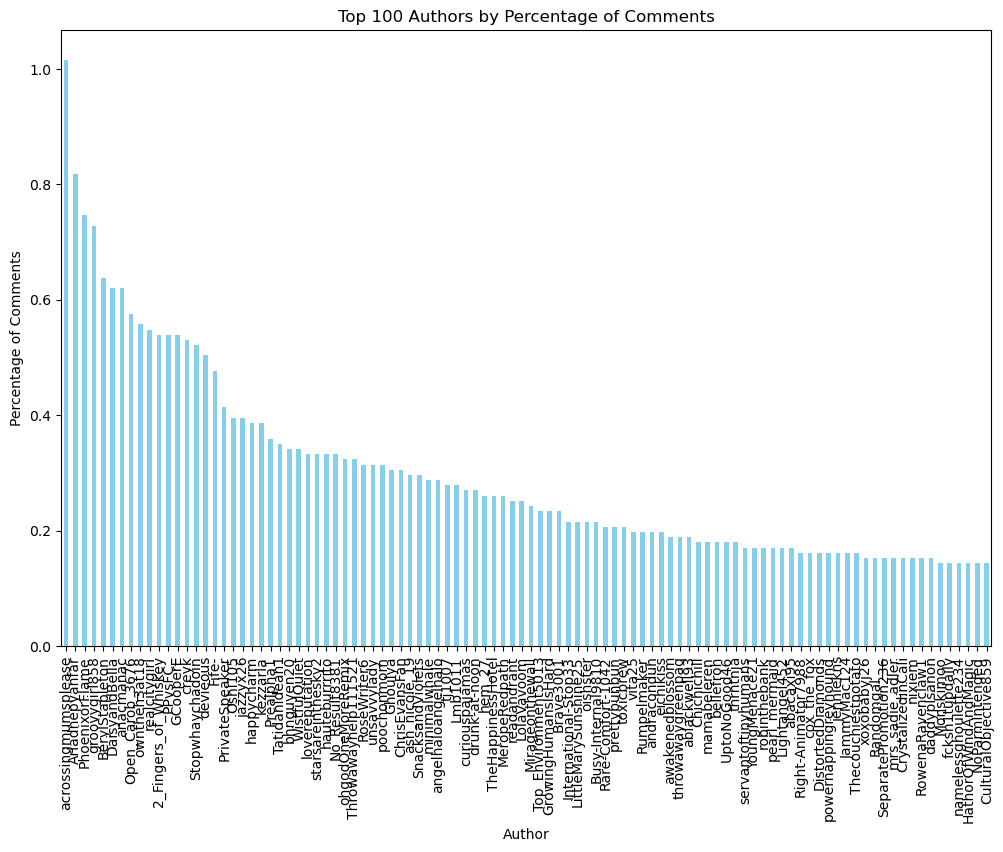

In [9]:
#Count comments per author
author_counts = all_seasons_df['author'].value_counts()
# Calculate the percentage of comments for each author
author_percentages = (author_counts / author_counts.sum()) * 100
#how many unique commenters are there? 
author_sample = author_counts[0:10].to_dict()
print('# of unique authors: ', len(author_counts))
print('# of deleted authors: ',author_sample['[deleted]'])
print('Sample of top 10 authors: ', author_sample)

# Number of top authors to display
top_n = 100

# Get the top N authors by percentage
# Count the number of comments for each author, excluding '[deleted]'
author_counts_excluding = all_seasons_df[all_seasons_df['author'] != '[deleted]']['author'].value_counts()

# Calculate the percentage of comments for each author
author_percentages_excluding = (author_counts_excluding / author_counts_excluding.sum()) * 100
top_authors = author_percentages_excluding.head(top_n)

# Calculate the average number of comments per author
average_comments_per_author = author_counts_excluding.mean()
print('Avg # of comments per author : ',average_comments_per_author)
# Plot the percentages
plt.figure(figsize=(12, 8))
top_authors.plot(kind='bar', color='skyblue', label='Top Authors')
plt.xlabel('Author')
plt.ylabel('Percentage of Comments')
plt.title(f'Top {top_n} Authors by Percentage of Comments')
plt.show()

Avg # of comments per author: 3.581320450885668


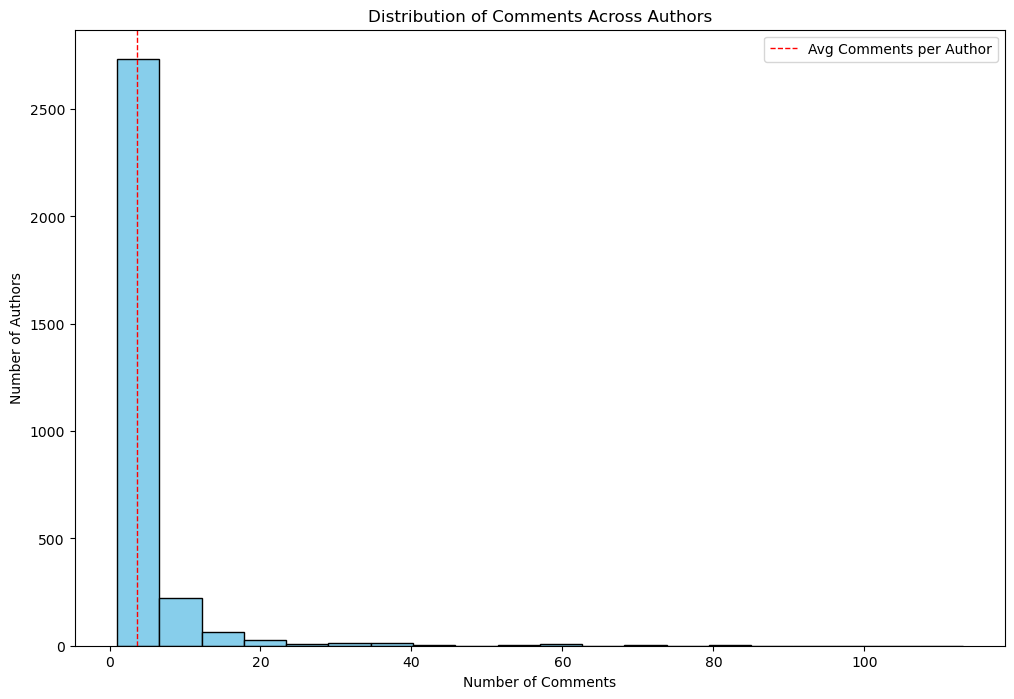

In [10]:
# Calculate the average number of comments per author
average_comments_per_author = author_counts_excluding.mean()
print('Avg # of comments per author:', average_comments_per_author)

# Plot the histogram
plt.figure(figsize=(12, 8))
plt.hist(author_counts_excluding, bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Number of Comments')
plt.ylabel('Number of Authors')
plt.title('Distribution of Comments Across Authors')
plt.axvline(x=average_comments_per_author, color='red', linestyle='dashed', linewidth=1, label='Avg Comments per Author')
plt.legend()
plt.show()

With ~3000 different authors, we see that the distribution is highly skewed to the right. The majority of authors post no more than 5 comments. A sharp decrease is observed in the number of authors that post more than 5 comments and we see even less authors posting more than 20 comments up to over 100 comments. We see that a large number of users contribute very few comments and some highly active super users contribute a disproportionate amount of comments. 

This can impact the sentiment analyis in several ways: 

 * Imbalanced Data - Sentiment may be biased towards users with more comments
 * Outlier Influence - Authors who are highly active may have extreme views that skew sentiment

Since I'm curious about the overall discussion sentiment, I don't take action to mitigate this. One strategy could be to limit comments by author and compare sentiment to all comments sentiment to see if there is a difference. Then, dive into individual sentiment per author on the highly active users only. This however, isn't a lot of data to work with and is not pursued in this analysis. 

In [11]:
#Get a subset of dataframe  
bgtn_df = all_seasons_df[['season','episode','post','body']].copy()

In [12]:
def group_by_season_episode(df):
    # Group by 'Season' and 'Episode' and aggregate 'body' into a list, keep season and episode
    grouped_df = df.groupby(['season', 'episode']).agg({
        'body': list,
        'season': 'first',
        'episode': 'first',
        'post': 'first'
    }).reset_index(drop=True)
    
    return grouped_df

# Group the df by season/ep
grouped_bgtn_df = group_by_season_episode(bgtn_df)  

# Print the grouped DataFrame
print(grouped_bgtn_df['body'].tail())

15    [[deleted], [deleted], [deleted], Okay it’s 7a...
16    [![gif](giphy|huJmPXfeir5JlpPAx0), [removed], ...
17    [“Same time tomorrow.”\nTHE SCREAM THAT I JUST...
18    [Omg 😂 the dream 💭 Colin!!!!, So, the dream is...
19    [I won't lie, something feels off about this s...
Name: body, dtype: object


## Sentiment Analysis of Comments Per Episode 

I selected VADER for sentiment analysis from NLTK. This was selected since it is specifically made for analyzing sentiment in social media which matches the domain of my data (Reddit Comments). 

In [13]:
#prep the data for vader 
def preprocess_for_vader(comments):
    # Initialize VADER sentiment analyzer
    sia = SentimentIntensityAnalyzer()
    
    # Preprocess sentences
    preprocessed_comments = []
    for comment in comments:
        # Convert to lowercase
        comment = comment.lower()

        # Remove special characters and punctuation (if necessary)
        comment = re.sub(r'[^a-zA-Z0-9\s]', '', comment)
        
        # Remove extra whitespace
        comment = ' '.join(comment.split())
        
        preprocessed_comments.append(comment)
    
    return preprocessed_comments

#apply preprocessing to grouped_bgtn_df
# Apply the preprocessing function to each row
grouped_bgtn_df['clean_sentences'] = grouped_bgtn_df['body'].apply(preprocess_for_vader)
#print(grouped_bgtn_df['clean_sentences'][19])

In [14]:
#run VADER per episode
def apply_vader(comments):
    sia = SentimentIntensityAnalyzer()
    scores = {'neg': 0, 'neu': 0, 'pos': 0, 'compound': 0}
    
    for comment in comments:
        score = sia.polarity_scores(comment) #returns dict of floats for sentiment strength based on input text 
        #print(score)
        scores['neg'] += score['neg']
        scores['neu'] += score['neu']
        scores['pos'] += score['pos']
        scores['compound'] += score['compound']
        #print(scores)
    
    # Average the scores
    num_comments = len(comments)
    for key in scores:
        scores[key] = scores[key] / num_comments
    return scores

In [15]:
# Apply VADER sentiment analysis to each row
grouped_bgtn_df['vader_scores'] = grouped_bgtn_df['clean_sentences'].apply(apply_vader)
# Add a column for the compound score
grouped_bgtn_df['avg_compound_score'] = grouped_bgtn_df['vader_scores'].apply(lambda x: x['compound'])
grouped_bgtn_df['season_episode'] = grouped_bgtn_df['season'].astype(str) + '.' + grouped_bgtn_df['episode'].astype(str)
#grouped_bgtn_df['season_episode'] = grouped_bgtn_df['season_episode'].astype(float)

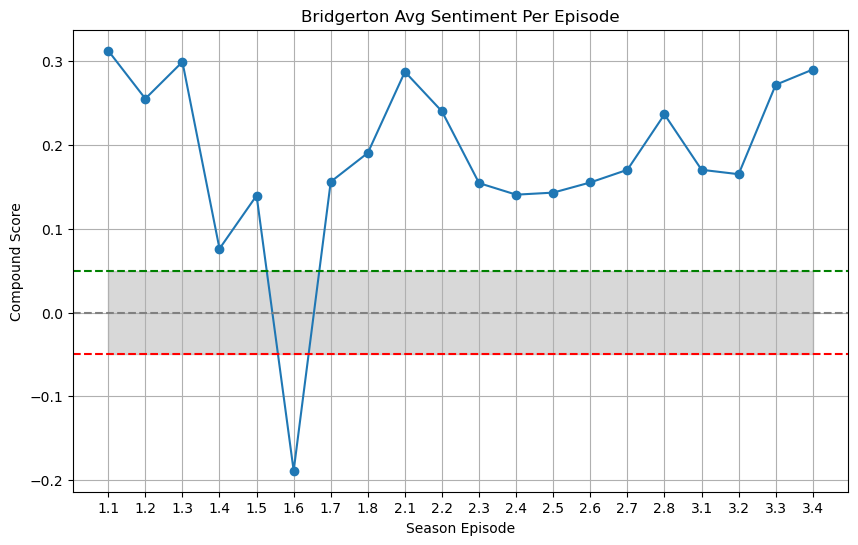

In [16]:
#visualize sentiment results per season/episode 
#grouped_bgtn_df.plot(x='season_episode', y='compound_score', style='o')

plt.figure(figsize=(10, 6))
plt.plot(grouped_bgtn_df['season_episode'], grouped_bgtn_df['avg_compound_score'], marker='o')

# Set ticks for each season_episode
plt.xticks(grouped_bgtn_df['season_episode'])

# Draw lines for positive, negative, and neutral bounds
plt.axhline(y=0, color='gray', linestyle='--', label='Neutral')
plt.axhline(y=0.05, color='green', linestyle='--', label='Positive Bound')
plt.axhline(y=-0.05, color='red', linestyle='--', label='Negative Bound')

# Add shading between the positive and negative bounds
plt.fill_between(grouped_bgtn_df['season_episode'], -0.05, 0.05, color='gray', alpha=0.3)


plt.xlabel('Season Episode')
plt.ylabel('Compound Score')
plt.title('Bridgerton Avg Sentiment Per Episode')
plt.grid(True)
plt.show()

By plotting the average sentiment per episode based on reddit comments, we may be able to determine which episodes were liked the most and the least. We see sentiment drop heavily for season 1 episode 6 in the graph, all other episodes have a positive average sentiment with the bounds defined. 

Its also possible that the sentiment is picking up negative sentiment towards a character or an event occurring rather than looking at this as the overall episode sentiment since these comments are not reviews or ratings focused on the episode but rather a discussion of the themes/topics/characters within the episode. 

The sentiment is mostly positive on average with the exception of season 1 episode 6. 

In episode 6, there are some highly controversial themes/topics surrounding marital lies, rape, and more. Without spoiling anything, it is a darker episode in a mostly lighthearted show with topics that people may find appalling. Therefore, it's not surprising we see so much negative sentiment on this specific episode. 

## Sentiment towards characters 

Now let's see what the sentiment is toward each character in a custom list of characters throughout each season. I picked the main characters and a couple of influential side characters to focus on. 

In picking the character names, I went with mostly first names or last names if the character is only really referred to as their last name. For example with "Lady Danbury", I just went with Danbury. It's not perfect if someone is referring to her as her first name "Agatha" it won't catch it and excludes any nicknames or pet names given and expressed in the comments such as "Polin" for "Penelope" and "Colin". 

In [17]:
# List of main character names, manually created 
character_names = [
    'Daphne', 'Simon', 'Anthony', 'Eloise', 'Penelope', 'Colin', 'Kate', 'Edwina',
    'Whistledown', 'Francesca', 'Cressida', 'Violet', 'Marina', 'Benedict', 'Mondrich',
    'Danbury','Queen'
                  ]

# Function to count character mentions in each row of df
def count_character_mentions(row):
    mentions = {name: 0 for name in character_names}
    for sentence in row['clean_sentences']:
        for name in character_names:
            if re.search(r'\b{}\b'.format(re.escape(name)), sentence, re.IGNORECASE):
                mentions[name] += 1
    return mentions

# Apply the function to each row
grouped_bgtn_df['character_mentions'] = grouped_bgtn_df.apply(count_character_mentions, axis=1)

#make the season+episode column for easier graphing
grouped_bgtn_df['season_episode'] = grouped_bgtn_df['season'].astype(str) + '.' + grouped_bgtn_df['episode'].astype(str)

# Print df, look at last episode as example
print(grouped_bgtn_df['character_mentions'].iloc[19])
print(grouped_bgtn_df['season_episode'].iloc[19])


{'Daphne': 47, 'Simon': 41, 'Anthony': 88, 'Eloise': 221, 'Penelope': 272, 'Colin': 566, 'Kate': 51, 'Edwina': 15, 'Whistledown': 78, 'Francesca': 133, 'Cressida': 208, 'Violet': 68, 'Marina': 35, 'Benedict': 110, 'Mondrich': 51, 'Danbury': 55, 'Queen': 64}
3.4


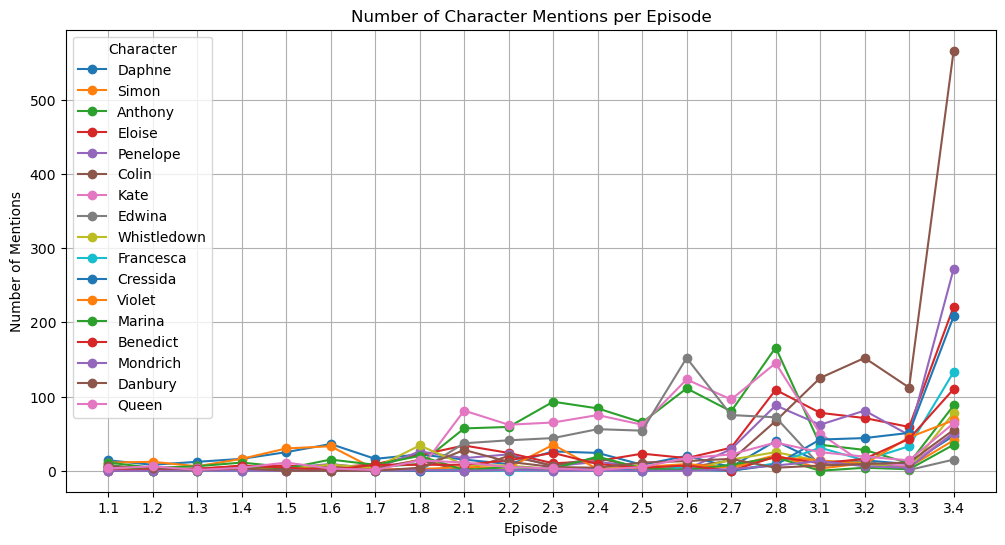

In [18]:
#Plot number of character mentions per episode
plt.figure(figsize=(12, 6))
for character in grouped_bgtn_df['character_mentions'][0].keys():
    mentions = [episode[character] for episode in grouped_bgtn_df['character_mentions']]
    plt.plot(grouped_bgtn_df['season_episode'], mentions, marker='o', label=character)

plt.xlabel('Episode')
plt.ylabel('Number of Mentions')
plt.title('Number of Character Mentions per Episode')
plt.legend(title='Character')
plt.grid(True)
plt.show()

We can get an idea of who the main focus is each episode/season by looking at the frequency of character mentions per episode in each season. In season 1, we see Daphne and Simon hovering above everyone else. In season 2, we see Kate, Anthony, and Edwina hovering above all the other points and in Season 3, Colin and Penelope arise above others. 

There large spike in mentions associated with season 3 is likely due to increased engagement in the Bridgerton Subreddit in the later seasons. We will confirm this later by looking at the # of comments per episode, but there is already some indication of data imbalance in season 1 comments versus season 2 & 3 observed when creating the dataframes . Earlier we looked at the length of the season 1 dataframe which is much smaller than the season 2 & 3 dataframe (roughly 1000 comments vs 10000 comments). 

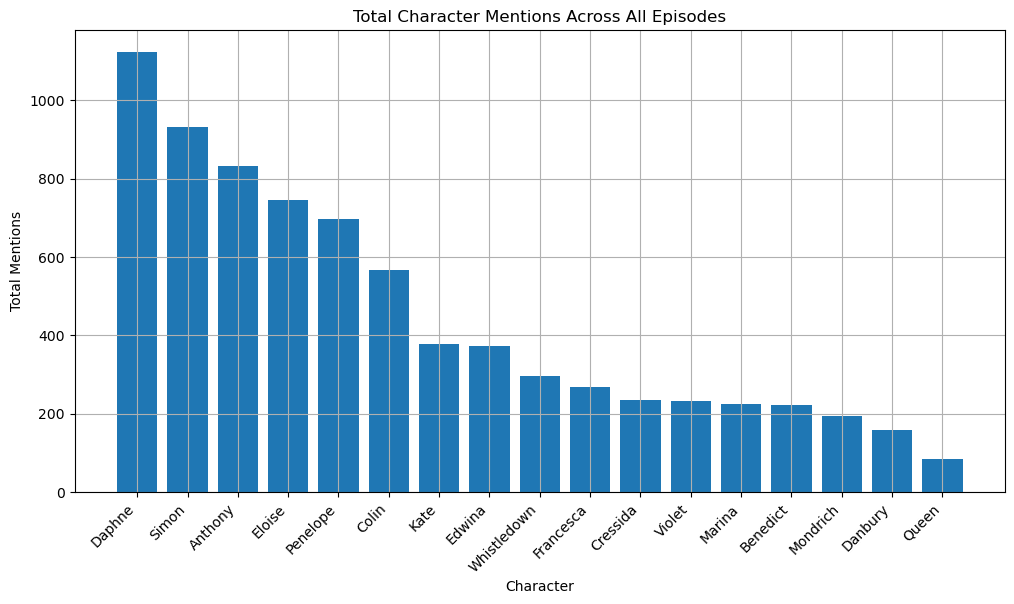

In [19]:
# Sum all character mentions across all episodes
total_mentions = {}
for episode_mentions in grouped_bgtn_df['character_mentions']:
    for character, mentions in episode_mentions.items():
        total_mentions[character] = total_mentions.get(character, 0) + mentions
        
# Sort total mentions by value in descending order
total_mentions_sorted = dict(sorted(total_mentions.items(), key=lambda x: x[1], reverse=True))

# Plot total character mentions across all episodes
plt.figure(figsize=(12, 6))
plt.bar(total_mentions.keys(), total_mentions_sorted.values())
plt.xlabel('Character')
plt.ylabel('Total Mentions')
plt.title('Total Character Mentions Across All Episodes')
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.show()

Daphne and Simon still appear to have the most mentions despite the data imbalance favoring seasons 2 & 3. They are the main focus of season 1, but are often mentioned to compare the season 2 & 3 love stories with since they were the first couple. With the completion of season 3 and the increased # of comments in the season 3 episodes, I would expect Colin and Penelope to overtake them when the season concludes. 

Interestingly, Eloise is mentioned a lot alongside the main couple characters, she is a supporting character that gets quite a bit of screen time due to her proximity to Whistledown and Penelope. 

In [20]:
# Function to create a new DataFrame with character mentions
def get_sentences_by_character(row):
    character_sentences = {name: [] for name in character_names}
    for sentence in row['clean_sentences']:
        for name in character_names:
            if re.search(r'\b{}\b'.format(re.escape(name)), sentence, re.IGNORECASE):
                character_sentences[name].append(sentence)
    character_df = pd.DataFrame({'characters': character_names, 'character_sentences': [character_sentences[name] for name in character_names]})
    character_df['season'] = row['season']
    character_df['episode'] = row['episode']
    character_df['season_episode'] = character_df['season'].astype(str) + '.' + character_df['episode'].astype(str)
    #if character is not mentioned, let's filter them out
    character_df = character_df[character_df["character_sentences"].str.len() != 0]
    return character_df

# Apply the function to each row and concatenate the results
character_df = pd.concat([get_sentences_by_character(row) for idx, row in grouped_bgtn_df.iterrows()], ignore_index=True)
print(character_df.head())
print(len(character_df))


  characters                                character_sentences season  \
0     Daphne  [its such a gorgeous show im so worried that d...      1   
1      Simon  [when i read shows discussions by episodes i e...      1   
2    Anthony  [i read daphn and anthonys books year ago but ...      1   
3     Eloise  [when i read shows discussions by episodes i e...      1   
4   Penelope  [when i read shows discussions by episodes i e...      1   

  episode season_episode  
0       1            1.1  
1       1            1.1  
2       1            1.1  
3       1            1.1  
4       1            1.1  
287


In [21]:
#Applying VADER to get overall reddit sentiment per character per episode 
# Apply VADER sentiment analysis to each row
character_df['vader_scores'] = character_df['character_sentences'].apply(apply_vader)
# Add a column for the compound score
character_df['avg_compound_score'] = character_df['vader_scores'].apply(lambda x: x['compound'])
print(character_df.head())

  characters                                character_sentences season  \
0     Daphne  [its such a gorgeous show im so worried that d...      1   
1      Simon  [when i read shows discussions by episodes i e...      1   
2    Anthony  [i read daphn and anthonys books year ago but ...      1   
3     Eloise  [when i read shows discussions by episodes i e...      1   
4   Penelope  [when i read shows discussions by episodes i e...      1   

  episode season_episode                                       vader_scores  \
0       1            1.1  {'neg': 0.07728571428571429, 'neu': 0.78421428...   
1       1            1.1  {'neg': 0.08218181818181819, 'neu': 0.80736363...   
2       1            1.1  {'neg': 0.07081818181818181, 'neu': 0.80109090...   
3       1            1.1  {'neg': 0.0894, 'neu': 0.7988000000000001, 'po...   
4       1            1.1  {'neg': 0.0904, 'neu': 0.7684, 'pos': 0.141400...   

   avg_compound_score  
0            0.571879  
1            0.523018  
2       

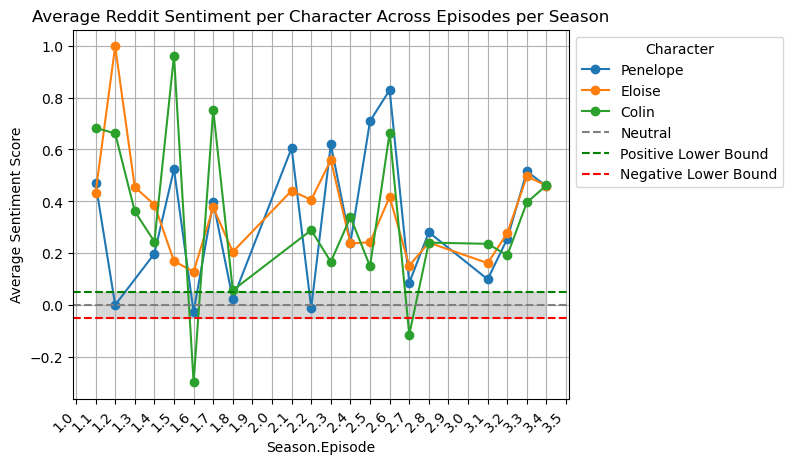

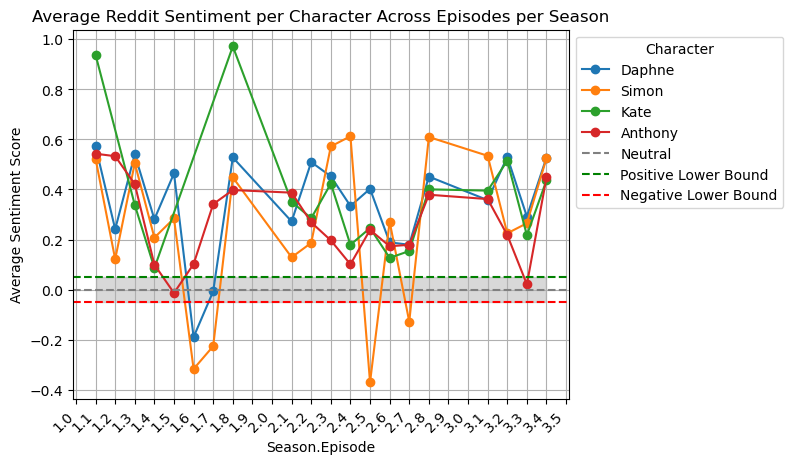

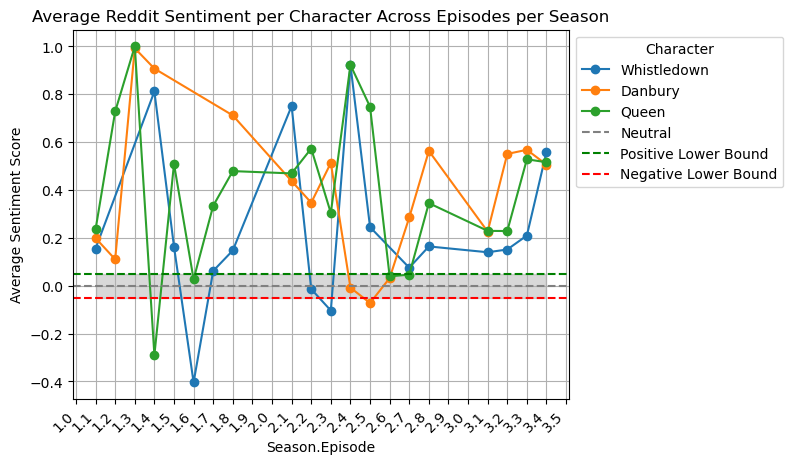

In [22]:
# Define a function to plot character sentiment across episodes
def plot_character_sentiment(df, characters_to_plot):
    #dataframe containing columns 'season_episode' and 'avg_compound_score' from vader function
    
    plt.figure()
    # Characters to plot
    characters_to_plot = characters_to_plot
    
    for character in characters_to_plot:
        character_data = df[df['characters'] == character]
        plt.plot(character_data['season_episode'].astype(float), character_data['avg_compound_score'], marker='o', label=character)
    
    # Draw lines for positive, negative, and neutral bounds
    plt.axhline(y=0, color='gray', linestyle='--', label='Neutral')
    plt.axhline(y=0.05, color='green', linestyle='--', label='Positive Lower Bound')
    plt.axhline(y=-0.05, color='red', linestyle='--', label='Negative Lower Bound')

    # Add shading between the positive and negative bounds
    plt.fill_between(df['season_episode'].astype(float), -0.05, 0.05, color='gray', alpha=0.3)
    
    plt.xlabel('Season.Episode')
    plt.ylabel('Average Sentiment Score')
    plt.title('Average Reddit Sentiment per Character Across Episodes per Season')
    plt.legend(title='Character', loc='upper left', bbox_to_anchor=(1, 1))
    plt.grid(True)
    # Set x-axis major locator to show every tick mark
    plt.gca().xaxis.set_major_locator(MultipleLocator(0.1))
    # Rotate x-axis tick labels
    plt.xticks(rotation=45,ha='right')
    plt.show()

plot_character_sentiment(character_df, ['Penelope','Eloise', 'Colin'])
plot_character_sentiment(character_df, ['Daphne','Simon', 'Kate', 'Anthony'])
plot_character_sentiment(character_df, ['Whistledown','Danbury','Queen'])


Now, I look at the average sentiment per episode of the top characters by mention:

1. Eloise, Penelope, Colin - Colin is the only character in this group that gets some slight negative sentiment. Penelope has some neutral epiosdes but mostly is positive. Eloise is overwhelmingly postive in most episodes.
2. Simon, Daphne, Anthony, Kate - These were chosen to compare against since they are the main love stories of seasons 1 & season 2. Again we see Simon getting some negative sentiment in the same season 1 episode 6 drama. Interestly, Simon isn't in season 2 but is still getting mentioned by redditors quite a bit in both a negative and positive sentiment throughout all episodes. Daphne, Kate, and Anthony mostly receive positive sentiment.
3. Danbury, Whistledown, and the Queen - these are the main creators of drama in the series, each encouraging the 'ton' to act on their whims. I expected to see a lot more negative sentiment than shown, but overall mostly positive with some more extreme dips into the negative for the queen and whistldown on a couple of episodes in season 1.  

/opt/anaconda3/lib/python3.11/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


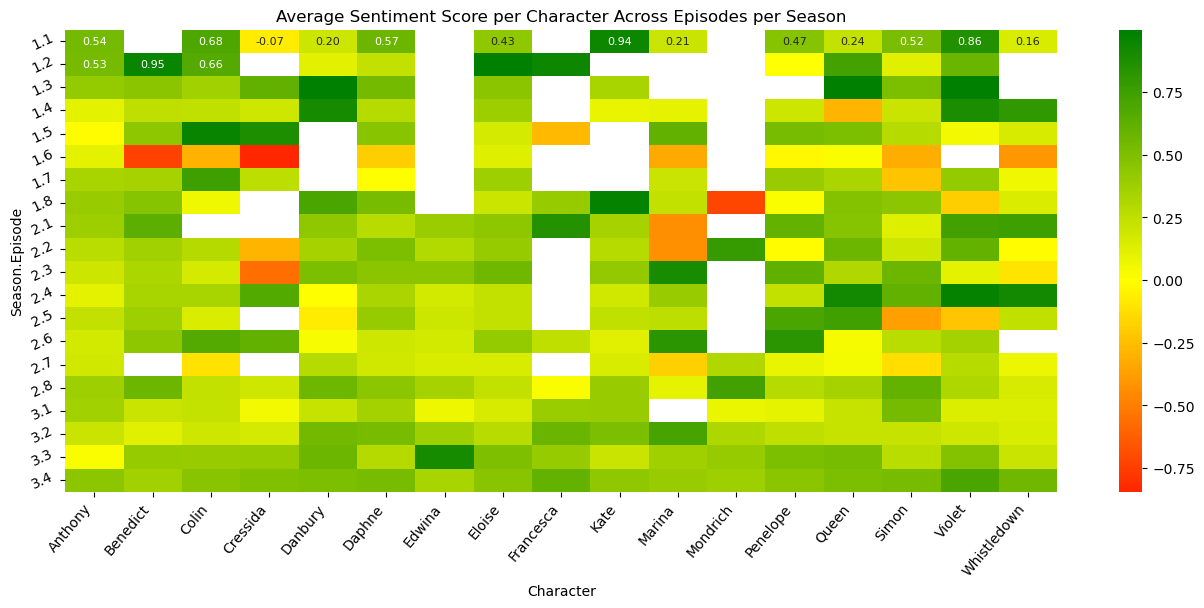

In [23]:
# Pivot the DataFrame to have seasons as rows, characters as columns, and average compound scores as values
heatmap_data = character_df.pivot(index='season_episode', columns='characters', values='avg_compound_score')
# Define custom colors for the color map
colors = [(0, 'red'), (0.5, 'yellow'), (1, 'green')]
cmap = LinearSegmentedColormap.from_list('custom', colors)

# Create the heatmap with custom color map
plt.figure(figsize=(16, 6))
ax=sns.heatmap(heatmap_data, annot=True, cmap=cmap, center=0, annot_kws={"size":8}, fmt='.2f')
plt.title('Average Sentiment Score per Character Across Episodes per Season')
plt.xlabel('Character')
# Rotate x-axis tick labels
ax.set_xticklabels(ax.get_xticklabels(), rotation=50, ha='right')
plt.ylabel('Season.Episode')
# Rotate y-axis tick labels
ax.set_yticklabels(ax.get_yticklabels(), rotation=25, ha='right')
plt.show()

Like sentiment per episode, sentiment per character is mostly positive in the heat map above(green). We do see some negative sentiment (red/orange) especially around characters rooted in the season 1 episode 6 drama discussed earlier. Negative sentiment also pops up with some of the side plots (Mondrich/Marina) that have some more controversial themes. Simon while not in season 2 or 3 is often compared/contrasted with other characters throughout comments in other episode post discussions. Edwina is not in season 1 and is not mentioned therefore her heatmap column shows white for season 1. Since this analysis includes both the book spoiler threads and show only threads so its common for discussion to include characters from other scenes episodes to drive a point. 

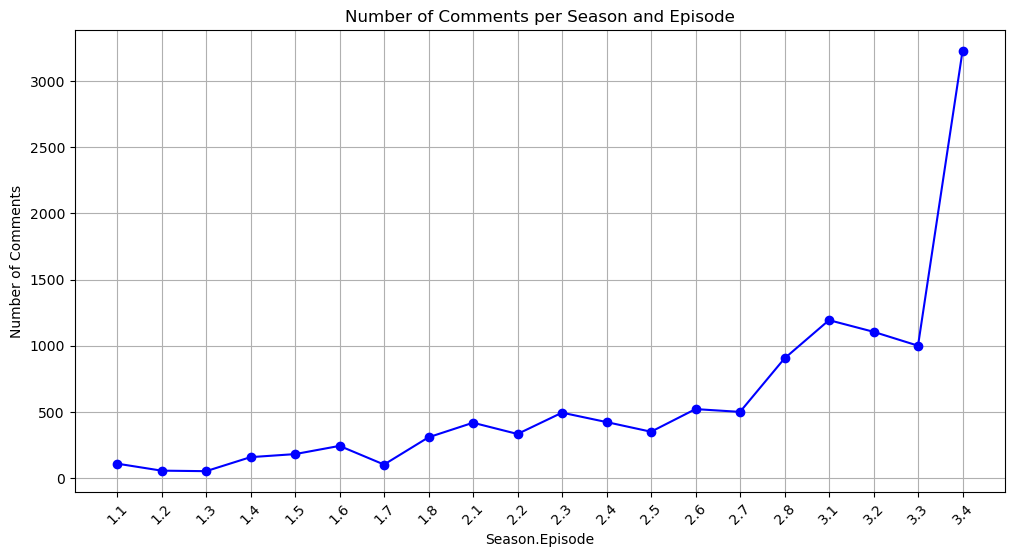

In [24]:
# Get length of each episodes comment history to understand if some episodes have more comments. 
grouped_bgtn_df['num_sentences'] = grouped_bgtn_df['clean_sentences'].apply(lambda x: len(x))

# Plot num_sentences per season_episode
plt.figure(figsize=(12, 6))
plt.plot(grouped_bgtn_df['season_episode'], grouped_bgtn_df['num_sentences'], marker='o', linestyle='-', color='b')
plt.xlabel('Season.Episode')
plt.ylabel('Number of Comments')
plt.title('Number of Comments per Season and Episode')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

Looking at the # of comments per episode, Season 3 episode 4 has the most. This could be due to the release schedule of this season, Netflix released all 4 episodes of season 3 at once, holding back the last 4 for a release in June 2024. This episode also ended with a big cliffhanger. It's possible that many users binged the first 4 episodes and went straight to the 4th episode to discuss the drama. Overall, we see a trend towards more comments per episode. 